Return true if training is successful : True
loading facial landmark predictor...
starting video stream thread...


KeyboardInterrupt: 

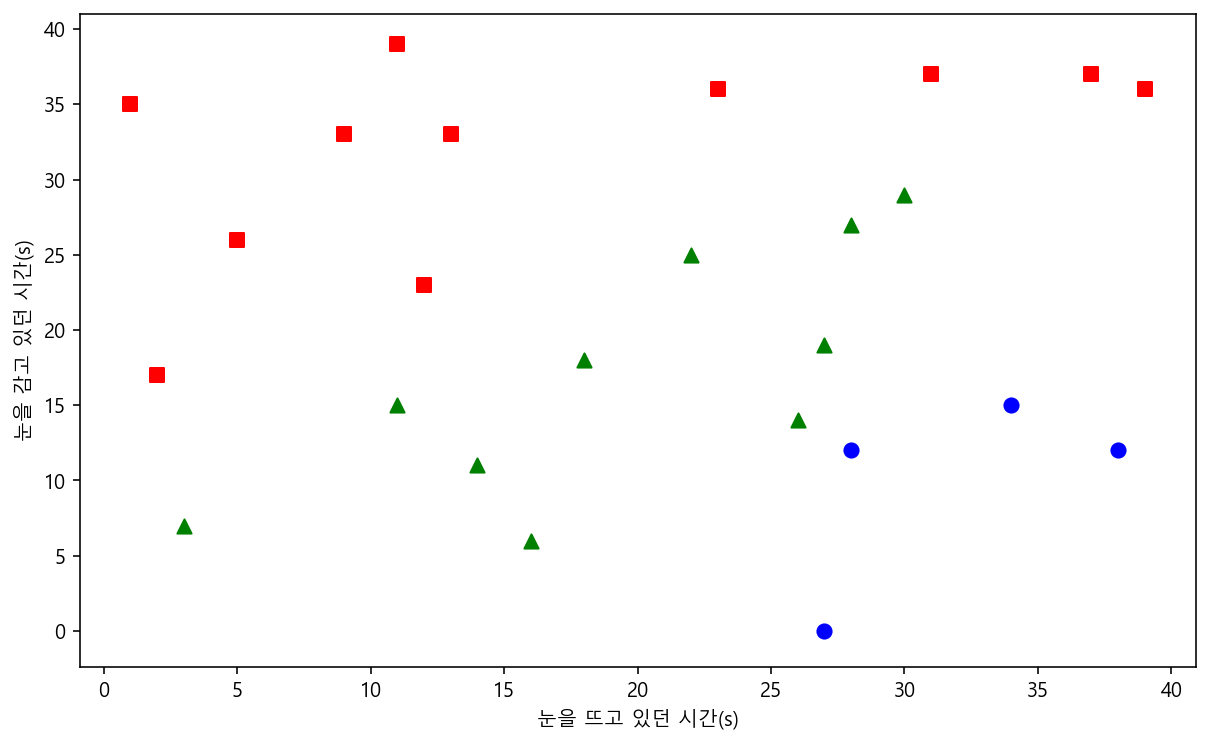

In [4]:
import numpy as np
import imutils
import time
import timeit
import dlib
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", family = "Malgun Gothic")

# 글씨가 뭉게져서 보이는 것 같으면 아래의 설정을 통해서 개선할 수 있음
from IPython.display import display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from scipy.spatial import distance as dist
from imutils.video import VideoStream
from imutils import face_utils
from threading import Thread
from threading import Timer
from check_cam_fps import check_fps
import make_train_data as mtd
import light_remover as lr
import ringing_alarm as alarm

def eye_aspect_ratio(eye) :
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear
    
def init_open_ear() :
    time.sleep(5)
    print("open init time sleep")
    ear_list = []
    th_message1 = Thread(target = init_message)
    th_message1.deamon = True
    th_message1.start()
    for i in range(7) :
        ear_list.append(both_ear)
        time.sleep(1)
    global OPEN_EAR
    OPEN_EAR = sum(ear_list) / len(ear_list)
    #print("open list =", ear_list)
    print("OPEN_EAR =", OPEN_EAR, "\n")

def init_close_ear() : 
    time.sleep(2)
    th_open.join()
    time.sleep(5)
    print("close init time sleep")
    ear_list = []
    th_message2 = Thread(target = init_message)
    th_message2.deamon = True
    th_message2.start()
    time.sleep(1)
    for i in range(7) :
        ear_list.append(both_ear)
        time.sleep(1)
    CLOSE_EAR = sum(ear_list) / len(ear_list)
    global EAR_THRESH
    EAR_THRESH = (((OPEN_EAR - CLOSE_EAR) / 2) + CLOSE_EAR) #EAR_THRESH means 50% of the being opened eyes state
    #print("close list =", ear_list)
    print("CLOSE_EAR =", CLOSE_EAR, "\n")
    print("The last EAR_THRESH's value :",EAR_THRESH, "\n")

def init_message() :
    print("init_message")
    alarm.sound_alarm("init_sound.mp3")

#####################################################################################################################
#1. Variables for checking EAR.
#2. Variables for detecting if user is asleep.
#3. When the alarm rings, measure the time eyes are being closed.
#4. When the alarm is rang, count the number of times it is rang, and prevent the alarm from ringing continuously.
#5. We should count the time eyes are being opened for data labeling.
#6. Variables for trained data generation and calculation fps.
#7. Detect face & eyes.
#8. Run the cam.
#9. Threads to run the functions in which determine the EAR_THRESH. 

#1. EAR을 체크하기 위한 변수들
OPEN_EAR = 0 # For init_open_ear()
EAR_THRESH = 0 # Threashold value,  For init_close_ear()

#2. 사용자가 자는 중인지 판단하기 위한 변수들
#It doesn't matter what you use instead of a consecutive frame to check out drowsiness state. (ex. timer)
EAR_CONSEC_FRAMES = 25 
COUNTER = 0 #Frames counter.

#3. 알람이 울렸을 때 눈을 감고 있는 시간을 측정
closed_eyes_time = [] #The time eyes were being offed.
TIMER_FLAG = False #Flag to activate 'start_closing' variable, which measures the eyes closing time.
ALARM_FLAG = False #Flag to check if alarm has ever been triggered.

#4. 알람이 울리는 중 일때, 울리는 시간을 세고 알람이 연속적으로 울리는 것을 막는다.
ALARM_COUNT = 0 #Number of times the total alarm rang.
RUNNING_TIME = 0 #Variable to prevent alarm going off continuously.

#5. 데이터 라벨링을 위해서 눈이 떠 있는 시간을 세야 한다.
PREV_TERM = 0 # 알람이 울리는 동안 눈이 떠있는 시간을 측정하기 위한 변수

#6. train 데이터를 만들고 & fps 계산을 위한 변수
np.random.seed(30)
power, nomal, short = mtd.start(25) #actually this three values aren't used now. (if you use this, you can do the plotting)
# mtd.plot_data(power, nomal, short)
#The array the actual test data is placed.
test_data = []
#The array the actual labeld data of test data is placed.
result_data = []
#For calculate fps
prev_time = 0

#7. Detect face & eyes.
print("loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector() # dlib에 있는 정면 얼굴 검출기
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") # 인식된 얼굴에서 랜드마크 찾기위한 클래스 생성

(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"] # 얼굴의 Landmarks에서 왼쪽 눈 인덱스들의 시작값과 끝 값
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"] # 얼굴의 Landmarks에서 오른쪽 눈 인덱스들의 시작값과 끝 값

#8. Run the cam.
print("starting video stream thread...")
vs = VideoStream(src=0).start()
time.sleep(1.0)

#9. Threads to run the functions in which determine the EAR_THRESH. 
th_open = Thread(target = init_open_ear)
th_open.deamon = True
th_open.start()
th_close = Thread(target = init_close_ear)
th_close.deamon = True
th_close.start()

#####################################################################################################################

while True:
    frame = vs.read()
    frame = imutils.resize(frame, width = 400)
    
    L, gray = lr.light_removing(frame)
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    rects = detector(gray,0) # detect faces in the image 'gray'(that is, grayscaled image).
    
    #checking fps. If you want to check fps, just uncomment below two lines.
    #prev_time, fps = check_fps(prev_time)
    #cv2.putText(frame, "fps : {:.2f}".format(fps), (10,130), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200,30,20), 2)

    for rect in rects: # loop over the faces.
        shape = predictor(gray, rect) # 얼굴 부위 찾기
        shape = face_utils.shape_to_np(shape)  # 얼굴 랜드마크를 넘파이로 변환

        leftEye = shape[lStart:lEnd] #  왼쪽 눈
        rightEye = shape[rStart:rEnd]   # 오른쪽 눈
        leftEAR = eye_aspect_ratio(leftEye)  # 왼쪽 눈 EAR
        rightEAR = eye_aspect_ratio(rightEye)  # 오른쪽 눈 EAR

        #(leftEAR + rightEAR) / 2 => both_ear. 
        both_ear = (leftEAR + rightEAR) * 500  # 범위 확장을 위해 1000을 곱함

        leftEyeHull = cv2.convexHull(leftEye) # 왼쪽눈을 포함하는 convex set들의 intersection
        rightEyeHull = cv2.convexHull(rightEye) # 오른쪽눈을 포함하는 convex set들의 intersection
        cv2.drawContours(frame, [leftEyeHull], -1, (0,255,0), 1) # 왼쪽 눈 그리기
        cv2.drawContours(frame, [rightEyeHull], -1, (0,255,0), 1) # 오른쪽 눈 그리기


        if both_ear < EAR_THRESH :          # 양쪽 눈의 EAR이 Threashold보다 작을 경우에(즉, 눈을 감기 시작할 때쯤)
            if not TIMER_FLAG:              # Timer_Flag가 False인 경우에는
                start_closing = timeit.default_timer()   # 눈을 감기 시작한 start_closing시간 측정하고
                TIMER_FLAG = True           # Timer_Flag를 True로 변경
            COUNTER += 1                    # 눈을 감은 횟수 1회 추가

            if COUNTER >= EAR_CONSEC_FRAMES:    # 이런식으로 카운터가 증가하여 EAR_CONSEC_FRAMES(=25) 이상이 되면

                mid_closing = timeit.default_timer()                  # mid_closing시간을 측정하고
                closing_time = round((mid_closing-start_closing),3)   # (mid - start_closing)을 소수점 네번째 자리에서 반올림

                if closing_time >= RUNNING_TIME:      # 위에서 설정한 closing_time이 Running_time 이상일때
                    if RUNNING_TIME == 0 :     # 만약 Running_time이 0이면 아래 네 줄과 같이 설정한다
                        CUR_TERM = timeit.default_timer()
                        OPENED_EYES_TIME = round((CUR_TERM - PREV_TERM),3)
                        PREV_TERM = CUR_TERM
                        RUNNING_TIME = 1.75

                    RUNNING_TIME += 2      # closing_time >= Running_time일 때 이 작업을 추가로 한다.
                    ALARM_FLAG = True      # closing_time >= Running_time일 때 이 작업을 추가로 한다.
                    ALARM_COUNT += 1       # closing_time >= Running_time일 때 이 작업을 추가로 한다.

                    print("ALARM {0}".format(ALARM_COUNT))  # 알람 카운트 print하기
                    print("The time eyes is being opened before the alarm went off :", OPENED_EYES_TIME)  # 눈 떠있는 시간 print
                    print("closing time :", closing_time)  # 눈 감은 시간 print
#                     test_data.append([22, 5])
                    test_data.append([OPENED_EYES_TIME, round(closing_time*10,3)])   # test_data에 눈 뜬 시간과 (감은시간*10) 추가
                    result = mtd.run([OPENED_EYES_TIME, closing_time*10], power, nomal, short) # (판단) 졸음 3가지 레벨 중 하나
                    result
                    result_data.append(result)     # result_data라는 리스트에 result를 추가
                    t = Thread(target = alarm.select_alarm, args = (result, ))  # 쓰레드로 동시에 알람 울림
                    t.deamon = True
                    t.start()

        else :  # both_ear >= EAR_THRESH 인 경우는 아래 처럼 초기화
            COUNTER = 0
            TIMER_FLAG = False
            RUNNING_TIME = 0

            if ALARM_FLAG : # ALARM_FLAG가 TRUE일때(즉, 163번째 라인의 코드가 활성화 했을 때, 즉, 처음 촬영시기 말고)
                end_closing = timeit.default_timer()  # end_closing에 시각 측정
                closed_eyes_time.append(round((end_closing-start_closing),3))
                print("The time eyes were being offed :", closed_eyes_time)  # 눈 감았던 시간 측정

            ALARM_FLAG = False   # ALARM_FLAG 초기화
        
        # EAR을 영상에 삽입
        cv2.putText(frame, "EAR : {:.2f}".format(both_ear), (300,130), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200,30,20), 2)

    cv2.imshow("Frame",frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break

cv2.destroyAllWindows()
vs.stop()
